# Bathtub Simulation

This example simulates the filling of a bathtub.

Variables:

- `capacity`: how much water the tub can contain
- `inflow_rate`: how much water is added per unit time
- `outflow_rate`: how much water goes down the drain per unit time

In [1]:
import torch
import pyro
from pyro.distributions import Normal, HalfNormal
import matplotlib.pyplot as plt
%matplotlib inline
pyro.set_rng_seed(42)

## How long will it take to fill up the tub?

In [2]:
def time_to_fill():
    capacity = pyro.sample('capacity', Normal(170.0, 40.0))
    inflow_rate = pyro.sample('inflow_rate', HalfNormal(1.0))
    # Inflow is assumed to be at least 1.0
    inflow_rate = 1.0 + inflow_rate
    outflow_rate = pyro.sample('outflow_rate', HalfNormal(0.2))
    # Outflow is assumed to be near zero and always less than inflow
    outflow_rate = min(outflow_rate, inflow_rate - 0.001)
    time = capacity / (inflow_rate - outflow_rate)
    return pyro.sample('time', Normal(time, 0.00001))

In [3]:
posterior = pyro.infer.Importance(time_to_fill, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites='time')
samples = torch.tensor([marginal().item() for _ in range(1000)])
torch.mean(samples)

tensor(119.6077)

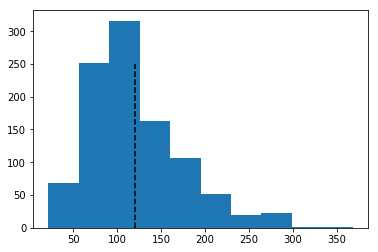

In [4]:
plt.hist(samples)
plt.vlines(torch.mean(samples), 0, 250, linestyles='dashed', colors='black');

## If we already know the size of the bathtub ...

In [5]:
conditioned_time_to_fill = pyro.condition(time_to_fill, data={'capacity': torch.tensor(350.)})

In [6]:
posterior = pyro.infer.Importance(conditioned_time_to_fill, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites='time')
samples = torch.tensor([marginal().item() for _ in range(1000)])
torch.mean(samples)

tensor(249.7917)

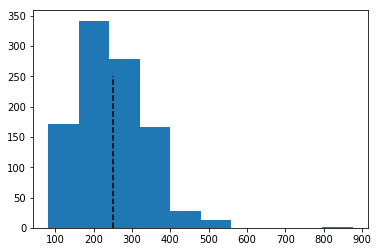

In [7]:
plt.hist(samples)
plt.vlines(torch.mean(samples), 0, 250, linestyles='dashed', colors='black');

## If we have observed a fill time and want to infer the capacity, etc.

In [8]:
observed_time = torch.tensor(300.)

In [9]:
conditioned_time_to_fill = pyro.condition(time_to_fill, data={'time': observed_time })

In [10]:
posterior = pyro.infer.Importance(conditioned_time_to_fill, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites=['capacity', 'inflow_rate', 'outflow_rate'])

In [11]:
capacity, inflow_rate, outflow_rate = marginal()
predicted_time = (capacity / (1.0 + inflow_rate - outflow_rate))
predicted_time, observed_time

(tensor(298.5624), tensor(300.))

In [13]:
capacity, 1.0 + inflow_rate, outflow_rate

(tensor(241.1679), tensor(1.0936), tensor(0.2859))